# Try this

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

I thought about trying to find some good data for you all to experiment with, but since I am currently interested in my own problem and am trying to write some abstracts, instead you get my data.

Please find two files attached to the Canvas page:
 - "eigen_target.dat" is a 5 column file with 30 rows.
 - "eigen_comparison.dat" is a 5 column file with 132 rows.
 
These files are the results of fitting 162 spectra with eigenvectors generated from the comparison sample.  The first column is the fit coefficients (amplitudes) for the first eigenvector, the second is the fit coefficients for the second eigenvector, and so on.  

It is clear that the distribution of coefficients is different for the target and comparison sample - cumulative histograms and even just a plot (see below) show this to be the case.

It is my feeling that:
 - the target data show a bimodal distribution
 - neither of the "peaks" of the bimodal distribution align particularly well with the peaks of the comparison data, so the target and comparison samples are not drawn from the same parent distribution.
 
Focusing, for the moment, on the coefficients for the first eigenvector (first column) explore the distributions of points for these two files.  Please comment on your results.  In particular, there aren't very many target points (only 30) so it seems probable that some of these methods might do better with fewer points than others.

(To make a nice plot, we'll extract the first two columns below.)

In [2]:
# pylab.rcParams['figure.figsize'] = (8, 7)

# r=np.loadtxt('eigen_target.dat')
# e1_target=r[:,0]
# e2_target=r[:,1]

# print (e1_target.shape)
# r=np.loadtxt('eigen_comparison.dat')
# e1_comparison=r[:,0]
# e2_comparison=r[:,1]
# print (e1_comparison.shape)

# plt.plot(e1_comparison,e2_comparison,'o',label='Comparison',markersize=10)
# plt.plot(e1_target,e2_target,'ro',label='Target',markersize=10)

# plt.xlabel('Eigenvector 1 Coefficient')
# plt.ylabel('Eigenvector 2 Coefficient')

# plt.legend()

# plt.savefig('e1_e2.png',bbox_inches='tight')

### Answer:

In [3]:
fn = '../../lectures/lecture10/eigen_target.dat'
eig_target = np.loadtxt(fn)[:, 0]

fn = '../../lectures/lecture10/eigen_comparison.dat'
eig_comparison = np.loadtxt(fn)[:, 0]

In [4]:
# a few standard bandwidths
sig_c = eig_comparison.std()
sig_t = eig_target.std()
N_c = len(eig_comparison)
N_t = len(eig_target)

silverman_c = 1.06 * sig_c / N_c**0.2
silverman_t = 1.06 * sig_t / N_t**0.2

fd_c = 2.7 * sig_c / N_c**(1 / 3)
fd_t = 2.7 * sig_t / N_t**(1 / 3)

Using basic histograms with bins of various sizes, I look at the estimated PDF of the coefficient of the first eigenvector. On the left, I use the Silverman bandwidth for each sample, in the middle I use the Freedman-Diaconis bandwidth for (generally) non-Gaussian distributions for each sample, and finally on the right I decrease the bin size to about 3 for each sample, showing a higher resolution bin number for each for comparison. The standardized bin sizes (bandwidths) I am treating as "well-representative" bin sizes for each sample.

From these histograms, we begin to see that the histograms with smaller bin sizes start to have a noticable peak toward the lower end (perhaps some sort of bimodal behavior from the population). This somewhat matches the comparison sample, but the comparison shows this in lesser quantity/amount. At least with the given bin sizes, the main peak of the target sample actually somewhat approximates that of the comparison sample. Playing around with bin sizes and shifting the bins, however, I *possibly* started to see a secondary peak just to the left (~-10) of the main peak for the target sample. However, I stuck with the binning technique coded below, and just illustrate a bin size of 3 for my highest resolution histogram.

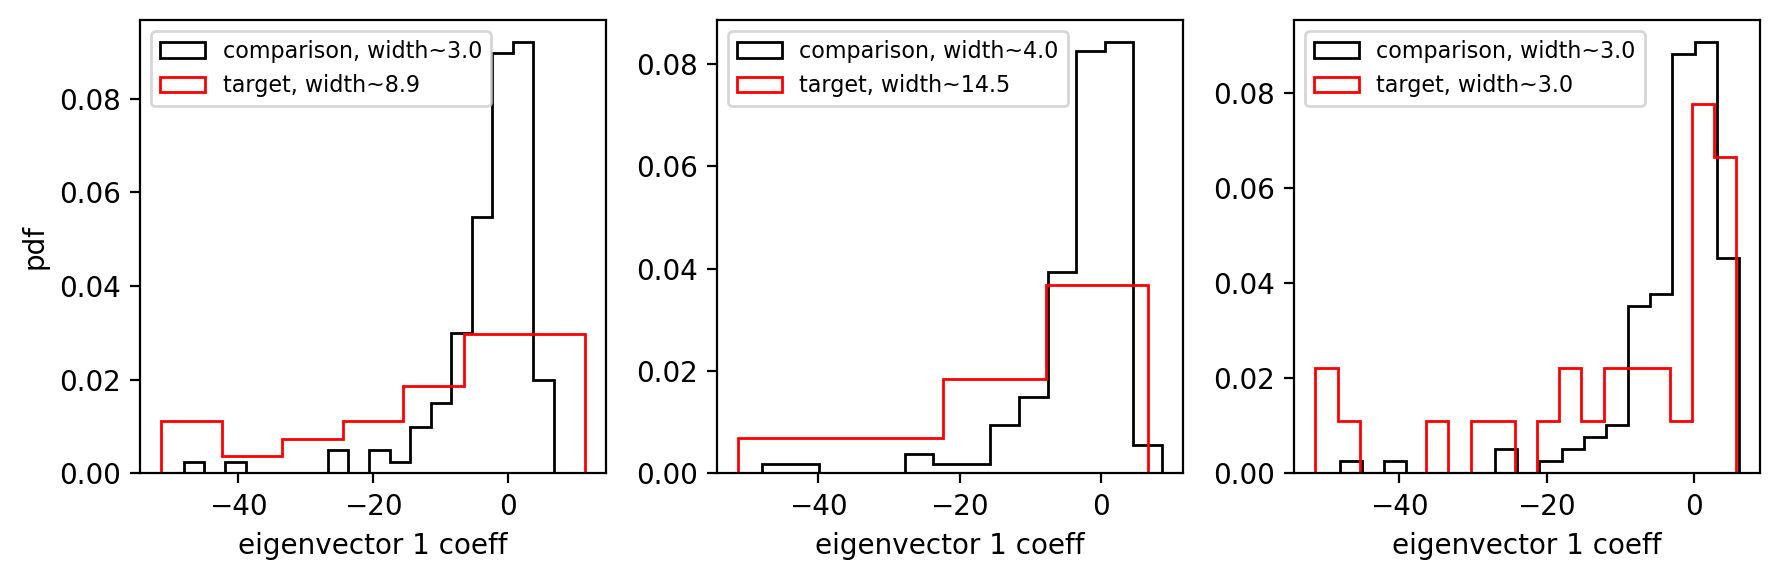

In [5]:
# histogram
def get_bins(sample, width):
    start = sample.min()
    stop = sample.max()
    n_bins = np.ceil((stop - start) / width) + 1
    bins = start + np.arange(n_bins) * width
    
    return bins

def make_hist(axis, bw_comp, bw_targ):
    bins_comp = get_bins(eig_comparison, bw_comp)
    bins_targ = get_bins(eig_target, bw_targ)

    axis.hist(eig_comparison, bins=bins_comp, histtype='step', density=True,
              color='k', label=f'comparison, width~{bw_comp:.1f}')
    axis.hist(eig_target, bins=bins_targ, histtype='step', density=True,
              color='r', label=f'target, width~{bw_targ:.1f}')

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(9, 3))

make_hist(ax[0], silverman_c, silverman_t)
make_hist(ax[1], fd_c, fd_t)
make_hist(ax[2], 3, 3)

[_ax.set_xlabel('eigenvector 1 coeff') for _ax in ax]
ax[0].set_ylabel('pdf')
[_ax.legend(loc='upper left', fontsize=8) for _ax in ax]

plt.tight_layout()
plt.show()

Below I used the KDE method using two kernels (Gaussian and Epanechnikov), and for each, I used the same 3 bandwidths. For some of the bandwidth/kernel combinations here, a second mode (or at least a more prominant asymmetry) is more visible just to the left of the main peak.

This ultimately suggests that there may indeed be some sort of bimodal distribution to the target sample, meaning at least part of that sample stems from a seperate distribution.

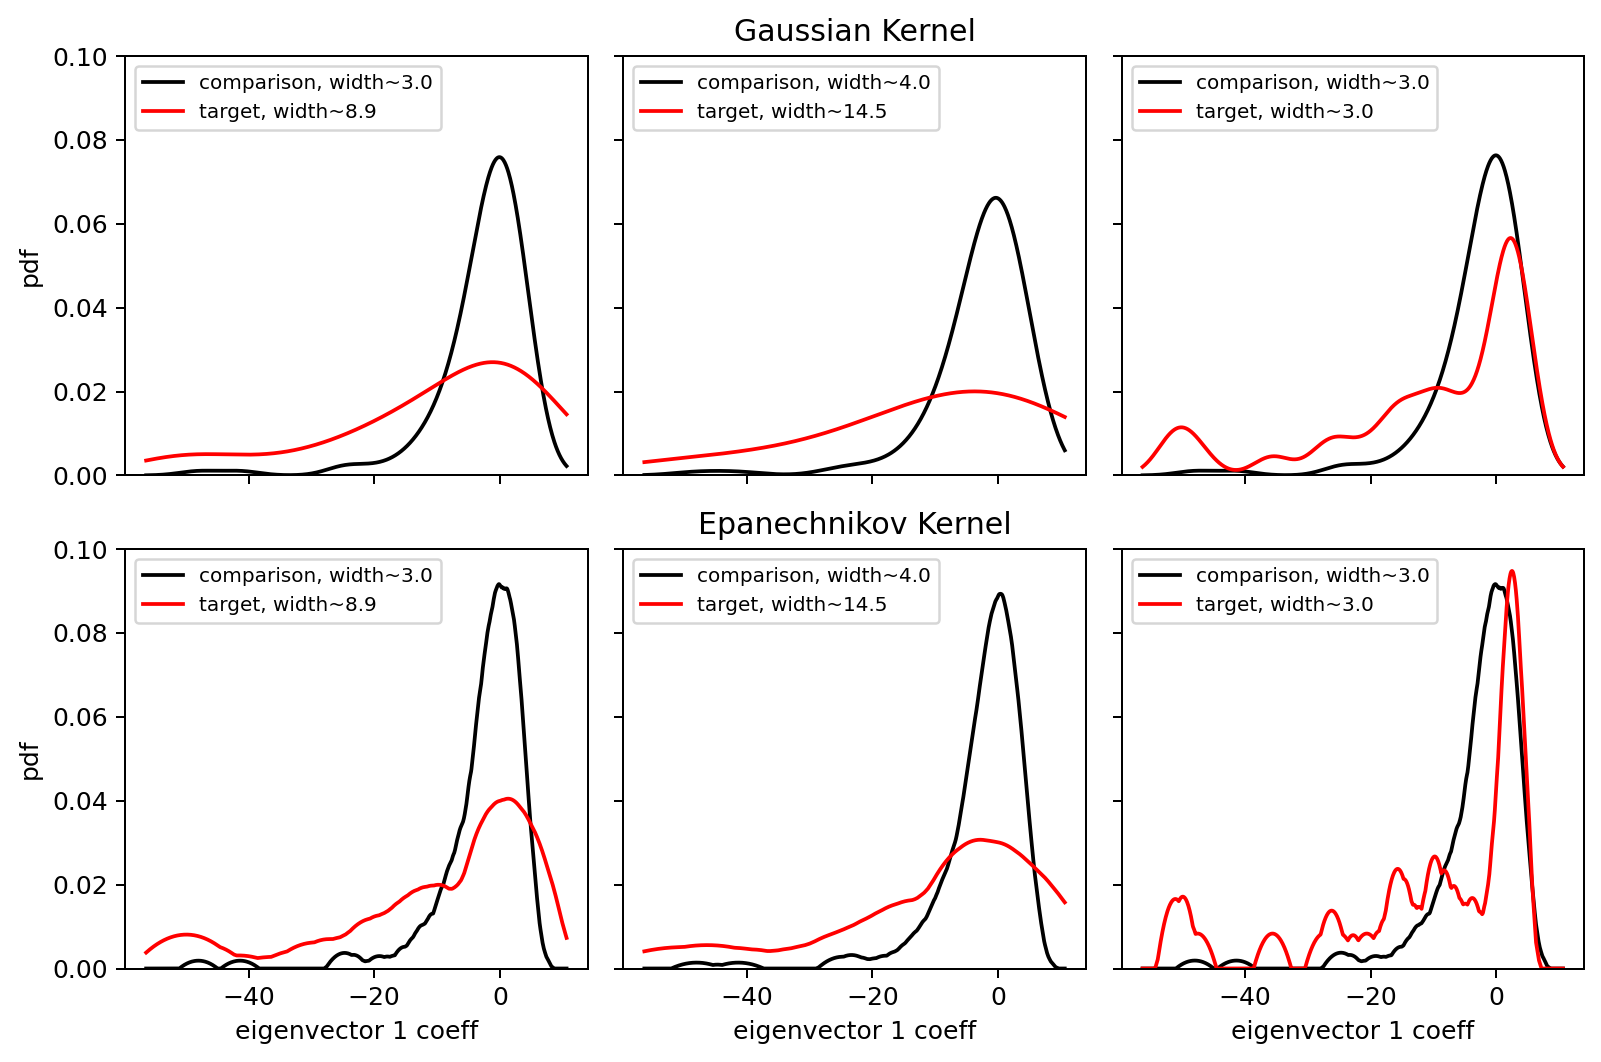

In [6]:
# KDE
x_min = np.min((eig_comparison.min(), eig_target.min())) - 5
x_max = np.max((eig_comparison.max(), eig_target.max())) + 5
x_plot = np.linspace(x_min, x_max, 1000)

def kde_pdf(sample, kernel, bandwidth):
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    kde_skl.fit(sample[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_plot[:, np.newaxis]) 

    return np.exp(log_pdf)

def make_kde(axis, kernel, bw_comp, bw_targ):
    pdf_comp = kde_pdf(eig_comparison, kernel, bw_comp)
    pdf_targ = kde_pdf(eig_target, kernel, bw_targ)

    axis.plot(x_plot, pdf_comp,
              c='k', label=f'comparison, width~{bw_comp:.1f}')
    axis.plot(x_plot, pdf_targ,
              c='r', label=f'target, width~{bw_targ:.1f}')

fig, ax = plt.subplots(2, 3, dpi=180, figsize=(9, 6), sharex=True, sharey=True)

make_kde(ax[0, 0], 'gaussian', silverman_c, silverman_t)
make_kde(ax[0, 1], 'gaussian', fd_c, fd_t)
make_kde(ax[0, 2], 'gaussian', 3, 3)

make_kde(ax[1, 0], 'epanechnikov', silverman_c, silverman_t)
make_kde(ax[1, 1], 'epanechnikov', fd_c, fd_t)
make_kde(ax[1, 2], 'epanechnikov', 3, 3)

[_ax.set_xlabel('eigenvector 1 coeff') for _ax in ax[1]]
[_ax[0].set_ylabel('pdf') for _ax in ax]
[_ax.set_ylim(0, 0.1) for _ax in ax.ravel()]
[_ax.legend(loc='upper left', fontsize=8) for _ax in ax.ravel()]

ax[0, 1].set_title('Gaussian Kernel')
ax[1, 1].set_title('Epanechnikov Kernel')

plt.tight_layout()
plt.show()